# Clustering locations of traffic cameras in Hong Kong using Amazon SageMaker and k-means

In [34]:
bucket_name = 'traffic-cameras-k-means'

In [33]:
import pandas as pd

cameras = pd.read_csv('Traffic_Camera_Locations_En.csv')
cameras.head()

,key,region,description,easting,northing,latitude,longitude,url
0,H429F,Hong Kong Island,Aberdeen Praya Road near Fish Market,833514,812196,22.248525,114.150158,http://tdcctv.data.one.gov.hk/H429F.JPG
1,H210F,Hong Kong Island,Aberdeen Tunnel - Wan Chai Side,836504,815117,22.274906,114.179164,http://tdcctv.data.one.gov.hk/H210F.JPG
2,H421F,Hong Kong Island,Aberdeen Tunnel - Aberdeen Side,836245,812386,22.250244,114.176651,http://tdcctv.data.one.gov.hk/H421F.JPG
3,H422F2,Hong Kong Island,Ap Lei Chau Bridge Road near Aberdeen Police S...,834632,812129,22.247922,114.161003,http://tdcctv.data.one.gov.hk/H422F2.JPG
4,H904F,Hong Kong Island,Canal Road Flyover near Gloucester Road,836731,815614,22.279394,114.181367,http://tdcctv.data.one.gov.hk/H904F.JPG


In [20]:
cameras.groupby('region').count()

,key,description,easting,northing,latitude,longitude,url,geometry
region,,,,,,,,
Hong Kong Island,34,34,34,34,34,34,34,34
Kowloon,58,58,58,58,58,58,58,58
Lantau,16,16,16,16,16,16,16,16
Shatin & Ma On Shan,24,24,24,24,24,24,24,24
"Tai Po, North & Yuen Long",31,31,31,31,31,31,31,31
Tsuen Wan,18,18,18,18,18,18,18,18
Tuen Mun & Tin Shui Wai,29,29,29,29,29,29,29,29


In [50]:
!pip install --upgrade pip --quiet
!pip install geopandas --quiet
!pip install descartes --quiet
!pip install mxnet --quiet

In [25]:
from geopandas import GeoDataFrame, points_from_xy

cameras_geo = GeoDataFrame(cameras, geometry=points_from_xy(cameras.longitude, cameras.latitude))
cameras_geo.head()

,key,region,description,easting,northing,latitude,longitude,url,geometry
0,H429F,Hong Kong Island,Aberdeen Praya Road near Fish Market,833514,812196,22.248525,114.150158,http://tdcctv.data.one.gov.hk/H429F.JPG,POINT (114.1501576 22.2485255)
1,H210F,Hong Kong Island,Aberdeen Tunnel - Wan Chai Side,836504,815117,22.274906,114.179164,http://tdcctv.data.one.gov.hk/H210F.JPG,POINT (114.1791642 22.27490622)
2,H421F,Hong Kong Island,Aberdeen Tunnel - Aberdeen Side,836245,812386,22.250244,114.176651,http://tdcctv.data.one.gov.hk/H421F.JPG,POINT (114.1766512 22.25024351)
3,H422F2,Hong Kong Island,Ap Lei Chau Bridge Road near Aberdeen Police S...,834632,812129,22.247922,114.161003,http://tdcctv.data.one.gov.hk/H422F2.JPG,POINT (114.1610034 22.24792186)
4,H904F,Hong Kong Island,Canal Road Flyover near Gloucester Road,836731,815614,22.279394,114.181367,http://tdcctv.data.one.gov.hk/H904F.JPG,POINT (114.1813669 22.2793944)


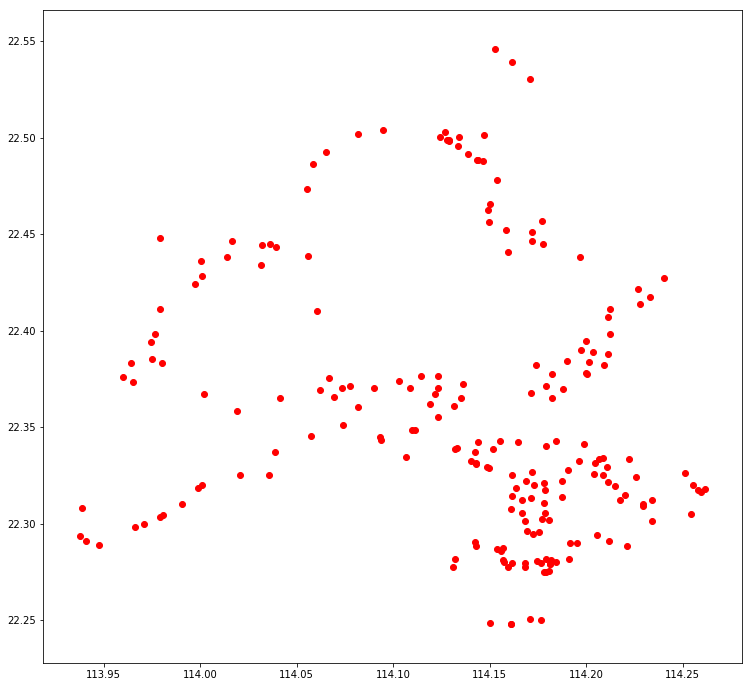

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [19, 12]

cameras_geo.plot(color='red')

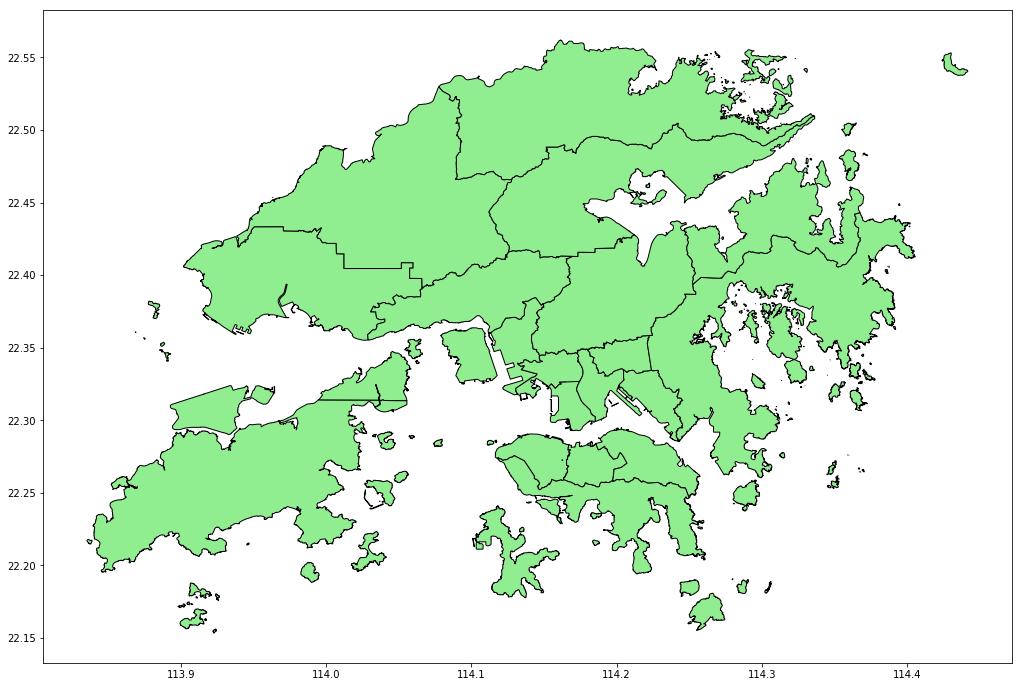

In [27]:
hong_kong = GeoDataFrame.from_file('Hong_Kong_18_Districts/')
hong_kong.plot(color='lightgreen', edgecolor='black')

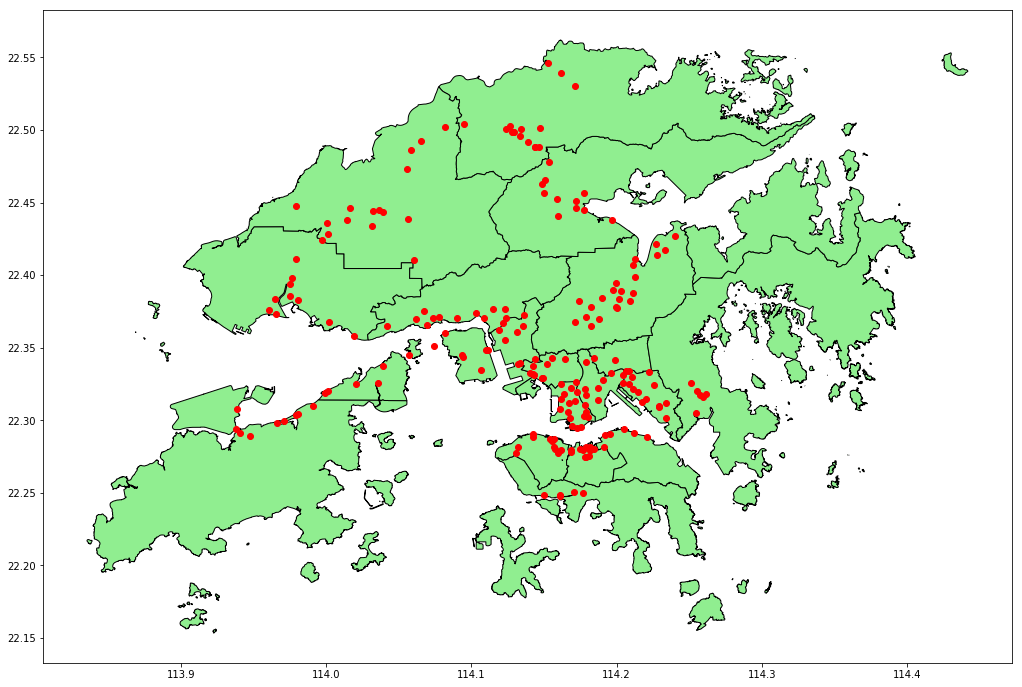

In [28]:
axes = hong_kong.plot(color='lightgreen', edgecolor='black')
cameras_geo.plot(ax=axes, color='red')

In [29]:
cameras.dtypes

key             object
region          object
description     object
easting          int64
northing         int64
latitude       float64
longitude      float64
url             object
geometry        object
dtype: object

In [30]:
from sagemaker import KMeans, get_execution_role

In [104]:
kmeans = KMeans(role=get_execution_role(),
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://' + bucket_name + '/',
                k=5)

In [105]:
train_df = cameras[['latitude', 'longitude']]
train_df.head()

,latitude,longitude
0,22.248525,114.150158
1,22.274906,114.179164
2,22.250244,114.176651
3,22.247922,114.161003
4,22.279394,114.181367


In [106]:
train_data = train_df.values.astype('float32')
train_data

array([[ 22.248526, 114.150154],
       [ 22.274906, 114.17916 ],
       [ 22.250244, 114.17665 ],
       [ 22.247921, 114.161   ],
       [ 22.279394, 114.181366],
       [ 22.279305, 114.181404],
       [ 22.281752, 114.19122 ],
       [ 22.285967, 114.15575 ],
       [ 22.286888, 114.15399 ],
       [ 22.277687, 114.159645],
       [ 22.281282, 114.18192 ],
       [ 22.28054 , 114.174446],
       [ 22.27971 , 114.176544],
       [ 22.281607, 114.179085],
       [ 22.27982 , 114.16856 ],
       [ 22.277832, 114.1685  ],
       [ 22.291067, 114.21197 ],
       [ 22.294012, 114.20541 ],
       [ 22.288265, 114.221146],
       [ 22.29022 , 114.195274],
       [ 22.275738, 114.180855],
       [ 22.281425, 114.15707 ],
       [ 22.28179 , 114.13231 ],
       [ 22.277582, 114.130875],
       [ 22.279827, 114.16167 ],
       [ 22.280369, 114.15765 ],
       [ 22.275042, 114.17837 ],
       [ 22.248283, 114.1611  ],
       [ 22.250559, 114.17069 ],
       [ 22.280117, 114.184616],
       [ 2

In [107]:
from datetime import datetime

job_name = 'traffic-cameras-k-means-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

In [108]:
%%time
kmeans.fit(kmeans.record_set(train_data), job_name=job_name)

2019-08-17 08:40:20 Starting - Starting the training job...
2019-08-17 08:40:35 Starting - Launching requested ML instances......
2019-08-17 08:41:33 Starting - Preparing the instances for training......
2019-08-17 08:42:29 Downloading - Downloading input data...
2019-08-17 08:43:20 Training - Training image download completed. Training in progress.
2019-08-17 08:43:20 Uploading - Uploading generated training model.
Docker entrypoint called with argument(s): train
[08/17/2019 08:43:16 INFO 139885536847680] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'

In [109]:
import boto3

model_key = job_name + '/output/model.tar.gz'
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

In [110]:
import os

os.system('tar -zxvf model.tar.gz')

0

In [111]:
os.system('unzip model_algo-1')

2304

In [112]:
import mxnet as mx

Kmeans_model_params = mx.ndarray.load('model_algo-1')
Kmeans_model_params

[
 [[ 22.399048 114.20034 ]
  [ 22.358242 114.10607 ]
  [ 22.374346 113.99153 ]
  [ 22.494183 114.13165 ]
  [ 22.303516 114.18555 ]]
 <NDArray 5x2 @cpu(0)>]

In [113]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = train_df.columns

In [114]:
cluster_centroids

,latitude,longitude
0,22.399048,114.200340
1,22.358242,114.106071
2,22.374346,113.991531
3,22.494183,114.131653
4,22.303516,114.185547


In [115]:
centroids_geo = GeoDataFrame(
    cluster_centroids, geometry=points_from_xy(cluster_centroids.longitude, cluster_centroids.latitude))

In [116]:
centroids_geo

,latitude,longitude,geometry
0,22.399048,114.200340,POINT (114.2003402709961 22.3990478515625)
1,22.358242,114.106071,POINT (114.106071472168 22.35824203491211)
2,22.374346,113.991531,POINT (113.9915313720703 22.37434577941895)
3,22.494183,114.131653,POINT (114.1316528320312 22.49418258666992)
4,22.303516,114.185547,POINT (114.185546875 22.30351638793945)


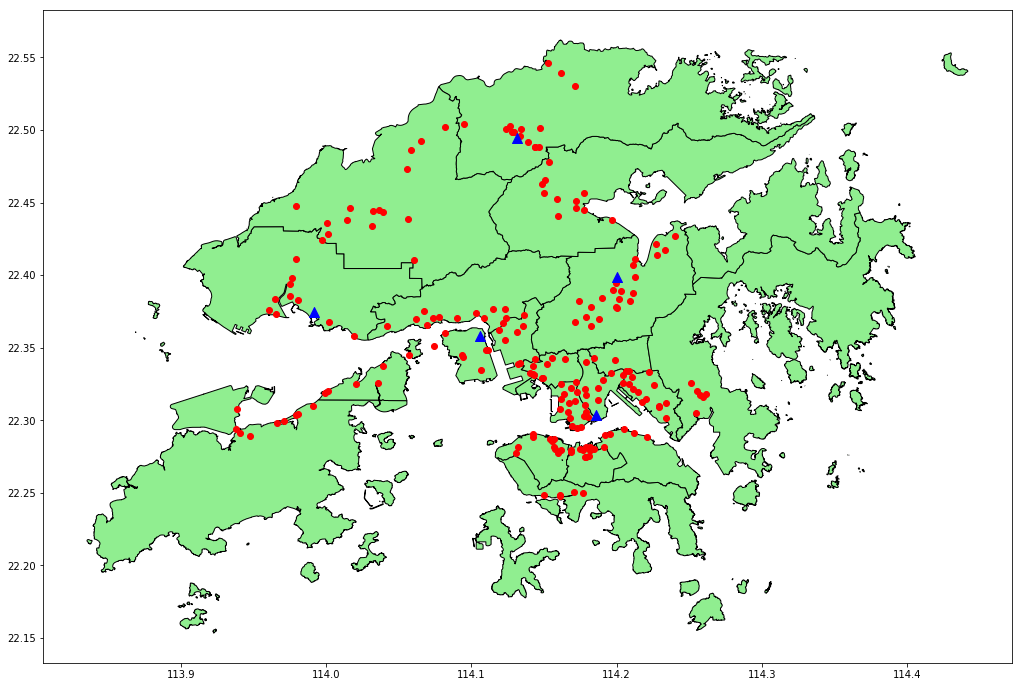

In [117]:
axes = hong_kong.plot(color='lightgreen', edgecolor='black')
cameras_geo.plot(ax=axes, color='red')
centroids_geo.plot(ax=axes, marker='^', color='blue', markersize=100)